# Analisis exploratorio: Kaggle-BirdCLEF2022

## ¿De qué información se dispone?

La información disponible para el proyecto de identificación de especies de aves mediante análisis bioacústicos (Kaggle-BirdCLEF2022) se compone de siete ficheros:
- *train_metadata.csv*: metadatos de los *training data*.
- *train_audio*: un conjunto de 14852 archivos sonoros en formato .ogg de diferentes especies de aves.
- *test_soundscapes*: un único archivo sonoro para realizar el test del modelo.
- *test.csv*: Metadatos de los datos para testear el modelo.
- *scored_birds.json*: listado de los nombres de las especies en formato corto.
- *eBird_Taxonomy_v2021.csv*: metadatos sobre las relaciones evolutivas de las diferentes especies.
- *sample_submission.csv*: archivo de ejemplo para realizar una submission en kaggle.


In [1]:
# Librerias

from utils.OpenZIP import *
import os
import pandas as pd
import geopandas
from shapely.geometry import Polygon
import zipfile as zf
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
# Rutas de guardado
path = os.getcwd()
zip_name = 'data.zip'

# Información disponible de la base de datos

print(f'Un total de {len(list_from_zip(path, zip_name))} ficheros:')
print(f"{len(searching_file(path, zip_name, '.csv'))} son csv")
print(f"{len(searching_file(path, zip_name, '.json'))} son es json")
print(f"Este fichero tiene tamaño {os.path.getsize(os.path.join(path, zip_name))} KB")


Un total de 6 ficheros:
4 son csv
2 son es json
Este fichero tiene tamaño 772448 KB


In [3]:
print(f"Lista de los archivos .csv:\n {searching_file(path, zip_name, '.csv')}")

Lista de los archivos .csv:
 ['eBird_Taxonomy_v2021.csv', 'sample_submission.csv', 'test.csv', 'train_metadata.csv']


## Taxonomía: ¿Hay que tener en cuenta la relación evolutiva entre las especies?

Las especies biológicas están clasificadas y ordenadas de manera jerárquica según criterios científicos. Estos criterios están basados en las relaciones de parentesco de los organismos y su historia evolutiva. Así, el sistema de clasificación más popular es el *cladista*, escuela que busca la secuencia de una población ancestral y todos sus descendientes. Los descendientes de un linaje se determinan según los cambios en la morfología respecto a su lineje o pariente ancestral. De esta manera, las especies se agrupan en *clados*, el conjunto de especies que proceden de un mismo ancestro y comparten ciertos caracteres o aspectos morfológicos, fiológicos o ecológicos. Esta similitud entre caracteres hace que dos especies se encuentren dentro del mismo reino, orden, familia o género en su clasificación. A su vez, estas similitudes pueden hacer complicada las diferenciación entre especies, hay casos en que su detección puede ser un proceso muy complicado. A veces, tan complicado que hay que acudir a técnicas más modernas (e.g., secuenciación del DNA). La clasificación de aves según su canto ha sido un aspecto poco estudiado, por lo que se desconoce si el hecho de que dos especies son evolutivamente más cercanas tengan cantos más parecidos. Para el modelo de clasificación, podría ser aspecto a prospectar para no tener un sesgo en las predicciones.

In [6]:
# Apertura de un csv procedente de un ZIP sin necesidad de descomprimir
taxonomy = open_csv(path, zip_name, 'eBird_Taxonomy_v2021.csv')

# Añadimos una columna que es el género de la especie
taxonomy['GENDER'] = taxonomy.SCI_NAME.str.split(expand=True)[0]

taxonomy.head()

Done!


,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS,GENDER
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,Struthio
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN,Struthio
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN,Struthio
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN,Rhea
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN,Rhea


La tabla de datos del archivo *taxonomy* presenta un total de 10 columnas, de las cuales ```GENDER``` ha sido añadida. De todas ellas, hay una de la que se desconoce su significado: ```CATEGORY```. En ella, encontramos un factor que se define como *species*. Realizamos una comparación entre los datos en bruto y los filtrados por ```CATEGORY``` escogiendo aquella que nos interesa para el proyecto (species)

In [7]:
# Información de la variable CATEGORY
print(f'Factores dentro de la columna CATEGORY:\n{taxonomy.CATEGORY.unique()}')
taxonomy.CATEGORY.value_counts()

Factores dentro de la columna CATEGORY:
['species' 'slash' 'issf' 'spuh' 'hybrid' 'domestic' 'form' 'intergrade']


species       10824
issf           3761
slash           788
spuh            666
hybrid          545
form            120
intergrade       34
domestic         15
Name: CATEGORY, dtype: int64

In [8]:
# Información de la variable TAXON_ORDER
print(f'Factores dentro de la columna TAXON_ORDER:\n{taxonomy.TAXON_ORDER.unique()}')
taxonomy.TAXON_ORDER.value_counts()

Factores dentro de la columna TAXON_ORDER:
[    1     6     7 ... 34698 34699 35000]


1        1
22553    1
22558    1
22559    1
22564    1
        ..
10266    1
10269    1
10272    1
10273    1
35000    1
Name: TAXON_ORDER, Length: 16753, dtype: int64

In [6]:
print('Datos de taxonomy en bruto')
print('-'*26)
print(f'Número de órdenes: {len(taxonomy.ORDER1.unique())}')
print(f'Número de familias: {len(taxonomy.FAMILY.unique())}')
print(f'Número de géneros: {len(taxonomy.GENDER.unique())}')
print(f'Número de especies: {len(taxonomy.SCI_NAME.unique())}')
print('\n')


# Filtramos por categoría escogiendo la especie
taxonomy2 = taxonomy[taxonomy['CATEGORY'] == 'species']
print('Datos de taxonomy filtrados')
print('-'*26)
print(f'Número de órdenes: {len(taxonomy2.ORDER1.unique())}')
print(f'Número de familias: {len(taxonomy2.FAMILY.unique())}')
print(f'Número de géneros: {len(taxonomy2.GENDER.unique())}')
print(f'Número de especies: {len(taxonomy2.SCI_NAME.unique())}')

Datos de taxonomy en bruto
--------------------------
Número de órdenes: 42
Número de familias: 250
Número de géneros: 2477
Número de especies: 16753


Datos de taxonomy filtrados
--------------------------
Número de órdenes: 41
Número de familias: 249
Número de géneros: 2333
Número de especies: 10824


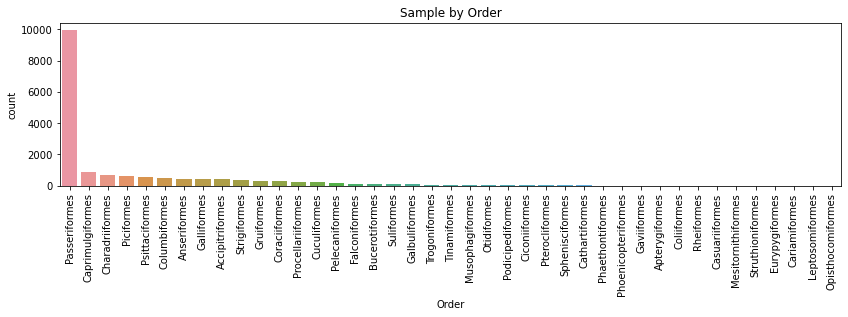

In [10]:
plt.figure(figsize=(14, 3))
sns.countplot(x='ORDER1', data=taxonomy, order=taxonomy['ORDER1'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Sample by Order')
plt.xlabel('Order')

plt.savefig('Graphics/taxonomy_order.png', facecolor='white')

plt.show()

# NOT RUN:
# Los gráficos presentan demasiadas categorias de familia y género para graficar
# plt.figure(figsize=(30, 3))
# sns.countplot(x='FAMILY', data=taxonomy, order=taxonomy['FAMILY'].value_counts().index)
# plt.xticks(rotation = 90)
# plt.title('Sample by Family')
# plt.xlabel('Family')
# plt.show()

# plt.figure(figsize=(50, 3))
# sns.countplot(x='GENDER', data=taxonomy, order=taxonomy['GENDER'].value_counts().index)
# plt.xticks(rotation = 90)
# plt.title('Sample by Gender')
# plt.xlabel('Gender')
# plt.show()
## Too large plots

Se observa que el número de muestras del orden de las paseriformes es el mayor de todos, con más de 6000 muestras. Este resultado se debe a que es el orden de aves más diversificado, donde se encuentran un inmenso númeor de especies. Esta diversidad se ve reflejada en la variabilidad de cantos que se pueden encontrar en este taxón. Algunos ejemplos más comunes de especies paseriformes son los gorriones, pinzones y jilgueros.

## Prospección de los metadatos
El archivo *train_csv* tiene la información de los archivos grabados (e.g., código de la especie, tipo de canto, calidad del audio,...). De esta información prospectaremos:
- Especies de la base de datos: cuántas especies están grabadas.
- Selección de especies para el modelo: es necesario trbajar con todas las especies incluidas en los metaddatos.
- El tipo de canto de las especies grabadas.
- Las lacalizaciones de las grabaciones: de dónde son las muestras recogidas.
- La calidad de las grabaciones.
- ¿La variable time es importante?.

In [8]:
# Apertura de un csv procedente de un ZIP sin necesidad de descomprimir
metadata = open_csv(path, zip_name, 'train_metadata.csv') # No hay duplicados
metadata.head()

Done!


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


### Especies en la base de datos

Número de especies grabadas: 152


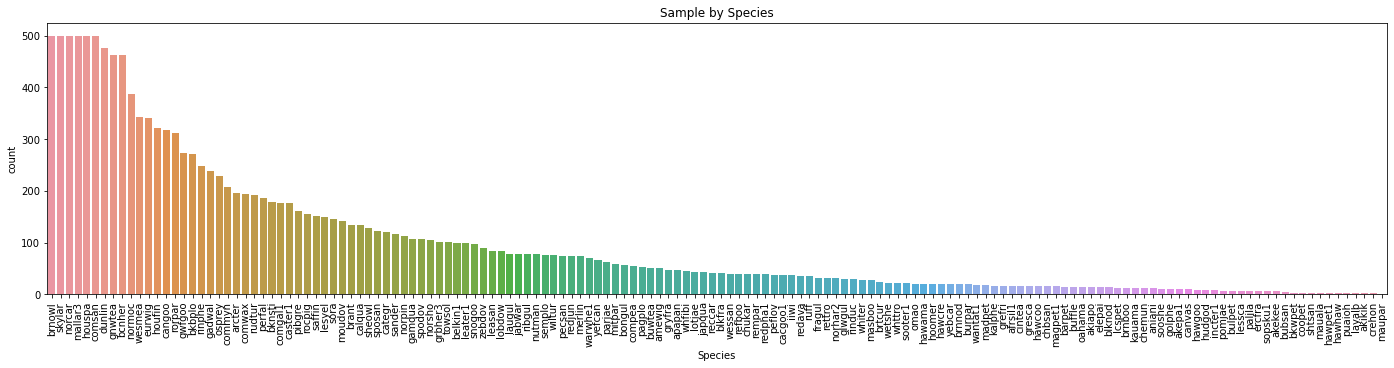

In [9]:
print(f"Número de especies grabadas: {len(metadata['primary_label'].unique())}")

plt.figure(figsize=(24, 5))
sns.countplot(x='primary_label', data=metadata, order=metadata['primary_label'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Sample by Species')
plt.xlabel('Species')
plt.show()

Existe una gran diferencia en el número de muestras por especie. Por ejemplo, 6 de ellas tiene hasta 500 grabaciones (segúramente porque son especies típicas), mientras que 10 de las especies solo tienen una muestra. 

#### CUIDADO: ¿Por qué hay un archivo json?

Dentro de la información aportada por la competición de [Kaggle](https://www.kaggle.com/competitions/birdclef-2022/overview), existe un archivo json con una lista de especies que han sido medidas. Aunque no sé especifica a quñe se refieren dentro de la descripción de los datos, uno de los *host* responde  a los usuarios que dado el elevado número de especies usado en la competición, es imposible categorizar y encontrar cada especie presente en las grabaciones adquiridas. Por tanto, únicamente un subconjunto de especies fueron categorizadas para cualquier audio.

In [15]:
spp = open_json(path, zip_name, 'scored_birds.json')

print(f'Número de especies catalogadas: {len(spp)}\nson:\n{spp}')

Done!
Número de especies catalogadas: 21
son:
['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']


Para el modelo de clasificación la base de datos se ha reducido sustancialmente. A partir de ahora, **se trabajará con las especies catalogadas en las grabaciones**.

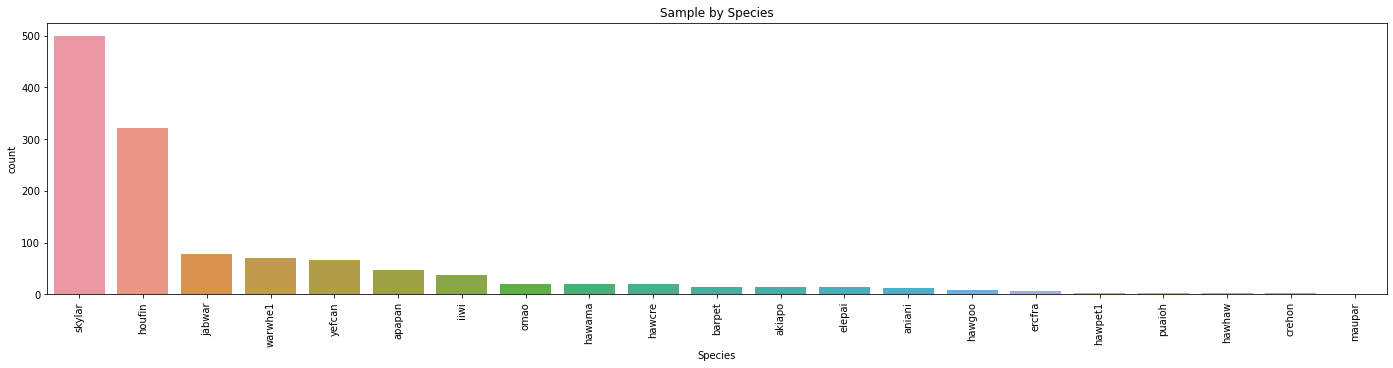

Número de muestras por especie:


,n_sample
primary_label,
skylar,500
houfin,322
jabwar,78
warwhe1,71
yefcan,67
apapan,47
iiwi,37
omao,21
hawama,21


In [35]:
spp_metadata=metadata[metadata['primary_label'].isin(spp)]

plt.figure(figsize=(24, 5))
sns.countplot(x='primary_label', data=spp_metadata, order=spp_metadata['primary_label'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Sample by Species')
plt.xlabel('Species')
plt.show()

# Resumen del gráfico

print('Número de muestras por especie:')
spp_metadata[['primary_label', 'secondary_labels']].groupby('primary_label').count()\
    .sort_values('secondary_labels', ascending=False).rename(columns={'secondary_labels': 'n_sample'})

### Análisis espacial: ¿todas las grabaciones son de Hawaii?

In [38]:
# Creación de una tabla de datos geopandas
geodf = geopandas.GeoDataFrame(spp_metadata,
        geometry=geopandas.points_from_xy(spp_metadata.longitude, spp_metadata.latitude),
        crs='EPSG:4326')

geodf.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,geometry
32,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg,POINT (-155.36150 19.62940)
33,akiapo,"['apapan', 'iiwi', 'warwhe1']",['call'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,17:46,https://www.xeno-canto.org/122401,akiapo/XC122401.ogg,POINT (-155.36150 19.62940)
34,akiapo,['apapan'],['song'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,16:22,https://www.xeno-canto.org/122693,akiapo/XC122693.ogg,POINT (-155.38960 19.66420)
35,akiapo,"['apapan', 'elepai', 'hawama', 'iiwi', 'omao',...",['call'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,3.5,15:58,https://www.xeno-canto.org/124705,akiapo/XC124705.ogg,POINT (-155.38960 19.66420)
36,akiapo,"['apapan', 'hawama', 'iiwi', 'omao', 'warwhe1']",['song'],19.6334,-155.3753,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,2.5,14:43,https://www.xeno-canto.org/124801,akiapo/XC124801.ogg,POINT (-155.37530 19.63340)


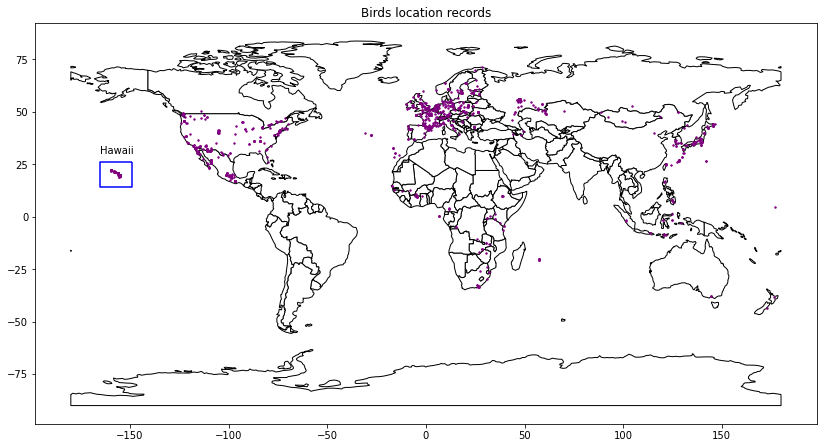

In [39]:
# Lo dibujamos en un mapa
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Creamos un polígono que indique dónde están el archipiélago de Hawaii
lon_points = [-149, -165,-165, -149, -149]
lat_points = [26, 26, 14, 14, 26]

polygon = Polygon(zip(lon_points, lat_points))
polygon = geopandas.GeoDataFrame(index=[0], crs=world.crs, geometry=[polygon]) 

ax = world.plot(color='white', edgecolor='black', figsize = (14,10))
geodf.plot(ax=ax, color='purple',  markersize=2, legend=True)
polygon.boundary.plot(ax=ax, color="blue")
plt.text(-165, 30, 'Hawaii')
plt.title('Birds location records')
plt.show()

In [41]:
# Sacamos la información de las especies grabadas en las islas

records_hawaii = geopandas.clip(geodf, polygon)

print(f'De las {len(spp_metadata.scientific_name.unique())} especies categorizadas \
en la base de datos,\nsólo {len(records_hawaii.scientific_name.unique())} especies \
fueron grabadas en Hawaii')

# Desabilitar geopandas
records_hawaii = pd.DataFrame(records_hawaii.drop(columns='geometry'))

De las 21 especies categorizadas en la base de datos,
sólo 19 especies fueron grabadas en Hawaii


### Tipo de canto de las grabaciones

No todos los sonidos emitidos por una especie o, incluso, por un individuo, son iguales. Un mismo individuo puede producir diferentes de sonidos diferentes dependiendo de la época del año en la que nos encontremos. Así, un canto (*song*) suena diferente a una llamada (*alarm call*). El primero se realiza durante la época de reproducción para buscar pareja mientras que el segundo es utilizado para alertar de algún peligro. En la mayoría de especies, las llamadas o cantos que realizan las aves son diferentes dependiendo de su ciclo vital, del sexo y del momento del año en la que nos encontremos. 

In [42]:
# Creamos un serie de todas las combinaciones de canto
type_call=pd.Series(spp_metadata['type'].apply(lambda x: ','.join(eval(x))))

print(f'Número de combinaciones de cantos {len(type_call.value_counts())}')

print(f'Los tipos de canto más grabados son:\n{type_call.value_counts().sort_values(ascending=False)[:10]}')

Número de combinaciones de cantos 133
Los tipos de canto más grabados son:
song                        473
call                        195
male,song                    85
flight call                  79
call,song                    71
adult,male,song              49
nocturnal flight call        22
call,flight call             19
adult,sex uncertain,song     13
adult,song                   13
Name: type, dtype: int64


Los tres tipos de sonido más comunes son los categorizados como ```call``` y ```song```. Las menos comunes son aquellas que tienen una amplica combinación en más tipos de cantos (e.g., cuando se escuchan varios individuos de diferentes sexos durante comportamientos distintos).

#### Qué es time

Existe una variable que se llama ```TIME``` que hay que saber si se considera a la duración de los audios o a la hora del día en que fueron grabados.

In [37]:
print(f"Hay {len(spp_metadata['time'].unique())} valores únicos de la columna time:\n{spp_metadata['time'].sort_values().unique()}")

# Calculamos los valores más repetidos
print(f"{spp_metadata['time'].value_counts().head(10)}")

Hay 391 valores únicos de la columna time:
['00:00' '00:08' '00:10' '00:18' '00:38' '00:42' '00:50' '01:00' '01:05'
 '01:30' '01:35' '01:38' '01:45' '01:52' '01:54' '02:00' '02:07' '02:30'
 '02:31' '02:32' '02:35' '02:59' '03:00' '03:09' '03:30' '03:31' '03:55'
 '04:00' '04:08' '04:30' '04:46' '04:49' '05:00' '05:08' '05:11' '05:19'
 '05:20' '05:25' '05:30' '05:34' '05:35' '05:37' '05:38' '05:40' '05:45'
 '05:46' '05:49' '05:50' '05:51' '05:58' '05:59' '06:00' '06:01' '06:02'
 '06:03' '06:04' '06:09' '06:10' '06:11' '06:13' '06:15' '06:18' '06:19'
 '06:20' '06:21' '06:22' '06:23' '06:29' '06:30' '06:34' '06:35' '06:40'
 '06:43' '06:44' '06:45' '06:46' '06:50' '06:52' '06:59' '07:00' '07:01'
 '07:02' '07:08' '07:10' '07:11' '07:12' '07:13' '07:18' '07:20' '07:21'
 '07:24' '07:25' '07:26' '07:27' '07:30' '07:33' '07:35' '07:36' '07:37'
 '07:38' '07:40' '07:42' '07:44' '07:45' '07:51' '07:55' '07:56' '07:57'
 '07:58' '08:00' '08:01' '08:03' '08:04' '08:05' '08:07' '08:08' '08:10'
 '08:12'

Parece que es la hora del día en el que está grabada, comprobamos al azar 10 audios por si coincide el tiempo de grabación y el valor de la columna ```TIME```, se observa que no coincide.

### Calidad de las grabaciones

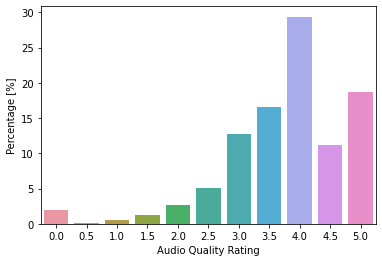

In [46]:
records=pd.DataFrame(spp_metadata.rating.value_counts(normalize=True).sort_index().rename_axis('Rating').reset_index(name='Count'))
records.Count=records.Count*100

# Ploteamos la calidad de los audios
sns.barplot(x="Rating", y="Count", data=records)
plt.ylabel('Percentage [%]')
plt.xlabel('Audio Quality Rating')
plt.show()

# Conclusiones

El trabajo final seleccionado pertenece a una competición de Kaggle cuyo objetivo es identificar especies mediante su sonido. El primer paso del proyecto es prospectar los datos disponibles para llevar a cabo el modelo de *Deep Learning*. Uno de los grandes inconvenientes ha sido la elevada cantidad de datos disponibles, que tienen un peso de más 6 Gb. Por ello, la plataforma seleccionada para la elaboración de este proyecto es **Google Colab**. La propección de los metadatos permite sacar las siguientes conclusiones:

1. Existe una gran diversidad de especies, la más diversa las especies procedente de la familia de las paseriformes, que a nivel taxonómico tiene relevancia pero deducimos que su relación evolutiva no tendrá peso a la hora de elaborar modelos. Esto se debe a que un mayor parentesco no se traduce en cantos similares, sino en morfologías similares. 
2. Dentro de las 152 especies recogidas en grabaciones únicamente 21 han sido catalogadas. Por tanto, de aquí en adelante, utilizaremos los archivos únicamente de esas 21 especies ya que en las grabaciones podemos encontrar especies no etiquetadas pudiendo llevar a confusión y a un mal entrenamiento del modelo.
3. Las 21 especies consideradas par el modelo fueron grabadas a lo largo de todo el globo, principalmente de la parte norte. En Hawaii 19 de las especies han sido muestreadas.
4. A la hora de realizar los modelos hay dos punto débiles que considerar:
    - Existen diferentes cantos para cada especie, los más muestreados son los etiquetados como llamadas (*calls*) y cantos (*songs*).
    - La calidad de las grabaciones es muy distinta, aunque más del 50% de las muestras de las 21 especies catalogadas tienen un calidad por encima del 3.
5. Existen especies con un número de muestras muy reducido (e.g., 1 muestra) lo que supondrá un reto a la hora de entrenar el modelo.